In [191]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.feature_selection import RFE

from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

In [192]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [193]:
print('Shape of training data:',train.shape)
print('Shape of testing data:',test.shape)
print(train.dtypes)

Shape of training data: (8012, 11)
Shape of testing data: (2671, 10)
Airline            object
Date_of_Journey    object
Source             object
Destination        object
Route              object
Dep_Time           object
Arrival_Time       object
Duration           object
Total_Stops        object
Additional_Info    object
Price               int64
dtype: object


In [194]:
# Check for missing Values
train.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [195]:
# Drop null values
train.dropna(inplace = True)
train.reset_index(drop = True, inplace = True) # Order Index

In [196]:
train.head(10)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,Airline C,12/06/2019,Delhi,Cochin,DEL → MAA → COK,20:40,09:25 13 Jun,12h 45m,1 stop,No info,7480
1,Airline A,18/06/2019,Banglore,Delhi,BLR → DEL,18:55,22:00,3h 5m,non-stop,No info,8016
2,Airline C,18/05/2019,Delhi,Cochin,DEL → BOM → COK,03:50,19:15,15h 25m,1 stop,No info,8879
3,Airline A,6/05/2019,Kolkata,Banglore,CCU → BOM → BLR,20:00,08:15 07 May,12h 15m,1 stop,In-flight meal not included,9663
4,Airline A,9/05/2019,Kolkata,Banglore,CCU → BOM → BLR,06:30,12:00,5h 30m,1 stop,In-flight meal not included,9663
5,Airline E,27/06/2019,Banglore,Delhi,BLR → DEL,05:55,08:35,2h 40m,non-stop,No info,3625
6,Airline A,3/06/2019,Delhi,Cochin,DEL → NAG → BOM → COK,14:35,12:35 04 Jun,22h,2 stops,In-flight meal not included,10919
7,Airline C,24/06/2019,Kolkata,Banglore,CCU → BLR,14:15,16:45,2h 30m,non-stop,No info,5510
8,Airline A,12/06/2019,Delhi,Cochin,DEL → BHO → BOM → COK,05:30,12:35,7h 5m,2 stops,No info,14441
9,Airline G,9/06/2019,Delhi,Cochin,DEL → BLR → COK,16:45,22:25,5h 40m,1 stop,No info,13470


In [197]:
# Extract Journey month & day from 'Date_of_journey'
def doj(df):
    df['journey_month'] = pd.to_datetime(df['Date_of_Journey']).dt.month
    df['journey_day'] = pd.to_datetime(df['Date_of_Journey']).dt.day
    df.drop('Date_of_Journey',axis = 1, inplace = True)
    return df

train = doj(train)
test = doj(test)

In [198]:
for i in range(train.shape[0]):
    if len(train.Route[i].split('→')) == 5:
        print('for flight at index ', i, ' Route is ',train.loc[i,'Route'], ' Total_stops = ', train.loc[i,'Total_Stops'])

for flight at index  545  Route is  CCU → DEL → COK → TRV → BLR  Total_stops =  3 stops
for flight at index  826  Route is  CCU → GAU → IMF → DEL → BLR  Total_stops =  3 stops
for flight at index  1435  Route is  DEL → RPR → NAG → BOM → COK  Total_stops =  3 stops
for flight at index  1439  Route is  DEL → RPR → NAG → BOM → COK  Total_stops =  3 stops
for flight at index  2376  Route is  CCU → BBI → IXR → DEL → BLR  Total_stops =  3 stops
for flight at index  2625  Route is  DEL → RPR → NAG → BOM → COK  Total_stops =  3 stops
for flight at index  2732  Route is  DEL → RPR → NAG → BOM → COK  Total_stops =  3 stops
for flight at index  2995  Route is  DEL → GWL → IDR → BOM → COK  Total_stops =  3 stops
for flight at index  3257  Route is  CCU → GAU → IMF → DEL → BLR  Total_stops =  3 stops
for flight at index  3259  Route is  DEL → GWL → IDR → BOM → COK  Total_stops =  3 stops
for flight at index  3300  Route is  BLR → CCU → BBI → HYD → DEL  Total_stops =  3 stops
for flight at index  36

In [199]:
# Correct number of stops
def correct_stops(df):
    for i in range(df.shape[0]):
        if df.Total_Stops[i][0] == 'n':
            df.Total_Stops[i] = 0
        else:
            df.Total_Stops[i] = df.Total_Stops[i][0]
        if len(train.Route[i].split('→')) > 4:
            df.Total_Stops[i] = 4
    return df

train = correct_stops(train)
test = correct_stops(test)

In [200]:
# Extract departure time
def dep_time(df):
    df['dep_hour'] = pd.to_datetime(df['Dep_Time']).dt.hour
    df['dep_min'] = pd.to_datetime(df['Dep_Time']).dt.minute
    df.drop('Dep_Time', axis = 1, inplace = True)
    return df

train = dep_time(train)
test = dep_time(test)

In [201]:
# Extract arrival time
def arr_time(df):
    df['arr_hour'] = pd.to_datetime(df['Arrival_Time']).dt.hour
    df['arr_min'] = pd.to_datetime(df['Arrival_Time']).dt.minute
    return df

train = arr_time(train)
test = arr_time(test)

In [202]:
# convert durration of fligth
def duration(df):
    df['dur_hour'] = 0
    df['dur_min'] = 0
    for i in range(df.shape[0]):
        if len(df['Duration'][i].split()) == 1:
            if 'h' in df['Duration'][i]:
                df['dur_hour'][i] = df['Duration'][i][:-1]
            else:
                df['dur_min'][i] = df['Duration'][i][:-1]
        else:
            df['dur_hour'][i] = df['Duration'][i].split()[0][:-1]
            df['dur_min'][i] = df['Duration'][i].split()[1][:-1]

    df.drop('Duration', axis = 1, inplace = True)
    return df
train = duration(train)
test = duration(test)

In [203]:
# Extract arrival day/month
def arr_day(df):
    df['arr_month'] = pd.to_datetime(df['Arrival_Time']).dt.month
    df['arr_day'] = pd.to_datetime(df['Arrival_Time']).dt.day
    for i in range(df.shape[0]):
        if len(df['Arrival_Time'][i].split()) < 3:
            df['arr_month'][i] = df['journey_month'][i]
            df['arr_day'][i] = df['journey_day'][i]

    df.drop('Arrival_Time', axis = 1, inplace = True)
    return df
train = arr_day(train)
test = arr_day(test)

In [204]:
# Find & store the intermediate airports in 3 separate column (as max no. of intermediate airports = 3)
def intermediate_airports(df):
    df.Route = df.Route.apply(lambda x: x.split(' → '))
    df['int_1'] = 'na'
    df['int_2'] = 'na'
    df['int_3'] = 'na'
    for i in range(df.shape[0]):
        if len(df.Route[i]) == 3:
            df['int_1'][i] = df.Route[i][1]
        elif len(df.Route[i]) == 4:
            df['int_1'][i] = df.Route[i][1]
            df['int_2'][i] = df.Route[i][2]
        elif len(df.Route[i]) == 5:
            df['int_1'][i] = df.Route[i][1]
            df['int_2'][i] = df.Route[i][2]
            df['int_3'][i] = df.Route[i][3]
    df.drop('Route', axis = 1, inplace = True)
    return df
train = intermediate_airports(train)
test = intermediate_airports(test)

In [206]:
# One-hot encoding, combining train & test as Source, Destination & Additional_Info have some non common values.
to_encode = ['Airline','Source','Destination','Additional_Info']
comb = train.append(test, ignore_index=True)
for i in to_encode:
    if i == 'Additional_Info':
        x_t = pd.get_dummies(comb[i])
        x_t = x_t.drop(['No info','No Info'], axis = 1)
    else:
        x_t = pd.get_dummies(comb[i], prefix=i, prefix_sep='_')
    comb = comb.join(x_t)
    comb.drop(i, axis = 1, inplace = True)
    
# Find all airports & save in all_airports
all_airports = []
for i in range(comb.shape[0]):
    if comb.int_1[i] not in all_airports:
        all_airports.append(comb.int_1[i])
    if comb.int_2[i] not in all_airports:
        all_airports.append(comb.int_2[i])
    if comb.int_3[i] not in all_airports:
        all_airports.append(comb.int_3[i])

# convert all airports into features in a separate dataframe df2
df2 = pd.DataFrame(columns = all_airports)
for i in range(comb.shape[0]):
    df2 = df2.append(pd.Series(0, index=df2.columns), ignore_index=True) #appending zeros in entire df2

# set 1 if intermediate airport is their in a particular flight   
for i in range(comb.shape[0]):
    if comb.int_1[i] != 'na':
        df2[comb.int_1[i]][i] = 1
    if comb.int_2[i] != 'na':
        df2[comb.int_2[i]][i] = 1
    if comb.int_3[i] != 'na':
        df2[comb.int_3[i]][i] = 1

# Remove 'na' column which was assigned in case of absence of intermediate airport 1,2 or 3.
df2.drop('na', axis = 1, inplace = True)

# join intermediate airport df to comb(train + test)
comb = comb.join(df2)

# drop int_1,int_2,int_3
comb.drop(['int_1','int_2','int_3'], axis = 1, inplace = True)

# separate train & test
train = comb.iloc[:train.shape[0],:]
test = comb.iloc[train.shape[0]:,:]
test.drop('Price',axis = 1, inplace = True) # remove null price column create in test due to combining with train df

In [165]:
# Check skewness 
train.iloc[:,:2].skew()

Total_Stops    0.55772
Price          1.93119
dtype: float64

In [166]:
# Treat Skewness of Flight price
train.Price = train.Price.apply(lambda x : np.log1p(x))
print('Skewness of Price after log',train.Price.skew())

Skewness of Price after log -0.2454134795049426


In [167]:
# Find correlated Features
correl = train.corr()
for i in range(correl.shape[0]):
    for j in range(correl.shape[1]):
        if (abs(correl.iloc[i,j]) > 0.8) & ( i != j):
            print(round(correl.iloc[i,j], 4), 'between ',correl.columns[j], '   &   ', correl.index[i], ' ')

0.9688 between  arr_day    &    journey_day  
0.9688 between  journey_day    &    arr_day  
1.0 between  Destination_Kolkata    &    Source_Chennai  
1.0 between  Destination_Cochin    &    Source_Delhi  
1.0 between  Destination_Banglore    &    Source_Kolkata  
1.0 between  Destination_Hyderabad    &    Source_Mumbai  
1.0 between  Source_Kolkata    &    Destination_Banglore  
1.0 between  Source_Delhi    &    Destination_Cochin  
1.0 between  Source_Mumbai    &    Destination_Hyderabad  
1.0 between  Source_Chennai    &    Destination_Kolkata  


In [168]:
print('Total number of Features = ', len(train.columns))
print(train.columns)

Total number of Features =  85
Index(['Total_Stops', 'Price', 'journey_month', 'journey_day', 'dep_hour',
       'dep_min', 'arr_hour', 'arr_min', 'dur_hour', 'dur_min', 'arr_month',
       'arr_day', 'Airline_Airline A', 'Airline_Airline B',
       'Airline_Airline C', 'Airline_Airline D', 'Airline_Airline E',
       'Airline_Airline F', 'Airline_Airline G', 'Airline_Airline H',
       'Airline_Airline I', 'Airline_Airline J', 'Airline_Airline K',
       'Airline_Airline L', 'Source_Banglore', 'Source_Chennai',
       'Source_Delhi', 'Source_Kolkata', 'Source_Mumbai',
       'Destination_Banglore', 'Destination_Cochin', 'Destination_Delhi',
       'Destination_Hyderabad', 'Destination_Kolkata', 'Destination_New Delhi',
       '1 Long layover', '1 Short layover', '2 Long layover', 'Business class',
       'Change airports', 'In-flight meal not included',
       'No check-in baggage included', 'Red-eye flight', 'MAA', 'BOM', 'NAG',
       'BHO', 'BLR', 'HYD', 'BDQ', 'DEL', 'JAI', 'IXC',

In [169]:
# Split data into Feature & target
X = train.drop('Price', axis =1)
y = train['Price'].copy()

# Feature Scaling
def scaling(df):
    ss = StandardScaler()
    df = ss.fit_transform(df)
    return df
    
X = scaling(X)
test = scaling(X)

In [170]:
# Make scorer for RMSLE
def rmsle(ytruez,ypredz):
    error = np.sqrt(mean_squared_log_error(ytruez, ypredz))
    return error
from sklearn.metrics import make_scorer
my_func = make_scorer(rmsle, greater_is_better=False)

# RMSLE scorer 2 (returns error when the price is at original scale(convert price back to original scale))
def rmsle2(ytruez,ypredz):
    error = np.sqrt(mean_squared_log_error(np.expm1(ytruez), np.expm1(ypredz)))
    return error
from sklearn.metrics import make_scorer
my_func2 = make_scorer(rmsle2, greater_is_better=False)

In [171]:
# k-fold cross validation for Ridge, RandomForestRegressor & XGBoost.
ri_cv = Ridge(max_iter = 1500)
rf_cv = RandomForestRegressor(n_jobs = 4)
xgb_cv = XGBRegressor()

print('RMSLE Errors for log1p(price)')
cv_en = cross_val_score(ri_cv, X, y, cv = 8, scoring = my_func).mean()
print('For ElasticNet :', -1 *cv_en)

cv_rf = cross_val_score(rf_cv, X, y, cv = 8, scoring = my_func).mean()
print('For RandomForestRegressor :', -1 *cv_rf)

cv_xgb = cross_val_score(xgb_cv, X, y, cv = 8, scoring = my_func).mean()
print('For XGBoost :', -1 *cv_xgb)

RMSLE Errors for log1p(price)
For ElasticNet : 0.02336870411642109
For RandomForestRegressor : 0.012392063083228218
For XGBoost : 0.012076805277496449


In [172]:
# split Data
xtrain,xtest,ytrain,ytest = train_test_split(X,y,test_size = 0.2,random_state = 14) 

In [173]:
# Feature Elimination using rfe with RandomForestEstimator
rf=RandomForestRegressor()
rfe = RFE(estimator = rf, step = 1, verbose =2)
rfe.fit(X,y)

selected_fs = pd.DataFrame({'features': train.drop('Price', axis = 1).columns,
                           'ranks': rfe.ranking_})
selected_fs = selected_fs.sort_values(by = 'ranks')

# Convert data to use only selected features
xtrain_rfe = rfe.transform(xtrain)
X = rfe.transform(X)
xtest_rfe = rfe.transform(xtest)
test_rfe = rfe.transform(test)

print('Number of selected Features by RFE = ', selected_fs[selected_fs['ranks'] == 1].shape[0], 'out of 84 features.')

Fitting estimator with 84 features.
Fitting estimator with 83 features.
Fitting estimator with 82 features.
Fitting estimator with 81 features.
Fitting estimator with 80 features.
Fitting estimator with 79 features.
Fitting estimator with 78 features.
Fitting estimator with 77 features.
Fitting estimator with 76 features.
Fitting estimator with 75 features.
Fitting estimator with 74 features.
Fitting estimator with 73 features.
Fitting estimator with 72 features.
Fitting estimator with 71 features.
Fitting estimator with 70 features.
Fitting estimator with 69 features.
Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 fe

In [174]:
#Ridge
en = Ridge()
ypred_en = en.fit(xtrain_rfe,ytrain).predict(xtest_rfe)

# Convert actual & predicted price to original scale
y_true_scale = []
pred_true_scale = []
for i in range(len(ytest)):
    y_true_scale.append((np.expm1(ytest.iloc[i])))
    pred_true_scale.append((np.expm1(ypred_en[i])))
    
en_rmse = np.sqrt(mean_squared_error(y_true_scale, pred_true_scale))
print('r2_  score: ', round(r2_score(y_true_scale, pred_true_scale),3))
print('test RMSE: ', round(en_rmse,3))
print('test RMSLE: ', rmsle(y_true_scale, pred_true_scale))

r2_  score:  0.701
test RMSE:  2650.559
test RMSLE:  0.24666759677744227


In [175]:
# RandomForestRegressor
rf=RandomForestRegressor(n_jobs = 4,random_state = 28)
ypred_rf = rf.fit(xtrain_rfe,ytrain).predict(xtest_rfe)
ypred_rf_train = rf.fit(xtrain_rfe,ytrain).predict(xtrain_rfe)

# Convert actual & predicted price to original scale
y_true_scale_train = []
y_true_scale = []
pred_true_scale = []
pred_true_scale_train = []
for i in range(len(ytest)):
    y_true_scale.append((np.expm1(ytest.iloc[i])))
    y_true_scale_train.append((np.expm1(ytrain.iloc[i])))
    pred_true_scale.append((np.expm1(ypred_rf[i])))
    pred_true_scale_train.append((np.expm1(ypred_rf_train[i])))
    
print('train r2_score: ',round(r2_score(y_true_scale_train,pred_true_scale_train),3),'test r2_score: ',round(r2_score(y_true_scale, pred_true_scale),3),'\n')
print('train RMSLE: ',round(rmsle(y_true_scale_train,pred_true_scale_train),2),'test RMSLE: ', round(rmsle(y_true_scale, pred_true_scale),2))
print('train rmse: ',round(np.sqrt(mean_squared_error(y_true_scale_train, pred_true_scale_train)),2),'test rmse: ',round(np.sqrt(mean_squared_error(y_true_scale,pred_true_scale)),2))

train r2_score:  0.947 test r2_score:  0.929 

train RMSLE:  0.06 test RMSLE:  0.12
train rmse:  1084.31 test rmse:  1291.76


In [176]:
# RandomForest Hyper-Parameter Tuning
gridrf = {
    'max_depth' : [20],
    'n_estimators' : [190],
    'max_features' : ['auto'],
    'min_samples_split':[6],
    'min_samples_leaf' : [2],
    'bootstrap' : [True]
}
gsrf = GridSearchCV(RandomForestRegressor(),gridrf,n_jobs=-1,verbose=2,scoring=my_func2, return_train_score=True)
gsrf.fit(X,y)

print('Best params after Tuning : ',gsrf.best_params_)
print('Best Gridsearch score =  ',gsrf.best_score_, '\n')
print('Gridsearchcv mean score while Training : ',gsrf.cv_results_['mean_train_score'])
print('Gridsearchcv mean score while Testing : ',gsrf.cv_results_['mean_test_score'])

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.9s finished


Best params after Tuning :  {'bootstrap': True, 'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 190}
Best Gridsearch score =   -0.12782298962719202 

Gridsearchcv mean score while Training :  [-0.08052883]
Gridsearchcv mean score while Testing :  [-0.12782299]


In [177]:
# XGBoost
xgb = XGBRegressor()
ypred_xgb = xgb.fit(xtrain_rfe,ytrain).predict(xtest_rfe)
ypred_xgb_train = xgb.fit(xtrain_rfe,ytrain).predict(xtrain_rfe)

# Convert to Original scale
y_true_scale_train = []
y_true_scale = []
pred_true_scale = []
pred_true_scale_train = []
for i in range(len(ytest)):
    y_true_scale.append((np.expm1(ytest.iloc[i])))
    y_true_scale_train.append((np.expm1(ytrain.iloc[i])))
    pred_true_scale.append((np.expm1(ypred_xgb[i])))
    pred_true_scale_train.append((np.expm1(ypred_xgb_train[i])))
    
print('train r2_score: ', round(r2_score(y_true_scale_train, pred_true_scale_train),3),'test r2_score: ', round(r2_score(y_true_scale, pred_true_scale),3), '\n')
print('train RMSLE: ', round(rmsle(y_true_scale_train, pred_true_scale_train),2),'test RMSLE: ', round(rmsle(y_true_scale, pred_true_scale),2))
print('train RMSE: ', round(np.sqrt(mean_squared_error(y_true_scale_train, pred_true_scale_train)),2),'test RMSE: ', round(np.sqrt(mean_squared_error(y_true_scale, pred_true_scale)),2))

train r2_score:  0.954 test r2_score:  0.917 

train RMSLE:  0.08 test RMSLE:  0.12
train RMSE:  1015.06 test RMSE:  1397.82


In [178]:
# XGBoost Hyper-parameter Tuning
grid = {
    'max_depth' : [6],'min_child_weight' : [2],
    'n_estimators' : [6000],
    'gamma' : [0],
    'subsample':[1],'colsample_bytree':[0.65],
    'reg_alpha':[0.1],
    'learning_rate' : [0.01]
}
gs1 = GridSearchCV(XGBRegressor(), grid, n_jobs=-1, verbose=2,scoring=my_func) #'neg_mean_squared_error'
gs1.fit(xtrain_rfe,ytrain)
ypred = gs1.predict(xtest_rfe)
ypred_train = gs1.predict(xtrain_rfe)

# Convert to Original scale
y_true_scale = []
y_true_scale_train = []
pred_true_scale = []
pred_true_scale_train = []
for i in range(len(ytest)):
    y_true_scale.append((np.expm1(ytest.iloc[i])))
    y_true_scale_train.append((np.expm1(ytrain.iloc[i])))
    pred_true_scale.append((np.expm1(ypred[i])))
    pred_true_scale_train.append((np.expm1(ypred_train[i])))
    
print('train r2_score: ', round(r2_score(y_true_scale_train, pred_true_scale_train),3),'test r2_score: ', round(r2_score(y_true_scale, pred_true_scale),3), '\n')
print('train RMSLE: ', round(rmsle(y_true_scale_train, pred_true_scale_train),2),'test RMSLE: ', round(rmsle(y_true_scale, pred_true_scale),2))
print('train RMSE: ', round(np.sqrt(mean_squared_error(y_true_scale_train, pred_true_scale_train)),2),'test RMSE: ', round(np.sqrt(mean_squared_error(y_true_scale, pred_true_scale)),2))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.0min finished


train r2_score:  0.979 test r2_score:  0.92 

train RMSLE:  0.06 test RMSLE:  0.11
train RMSE:  692.74 test RMSE:  1369.5


In [179]:
print(gs1.best_params_)
print(gs1.best_score_)

{'colsample_bytree': 0.65, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 2, 'n_estimators': 6000, 'reg_alpha': 0.1, 'subsample': 1}
-0.01217914691253998


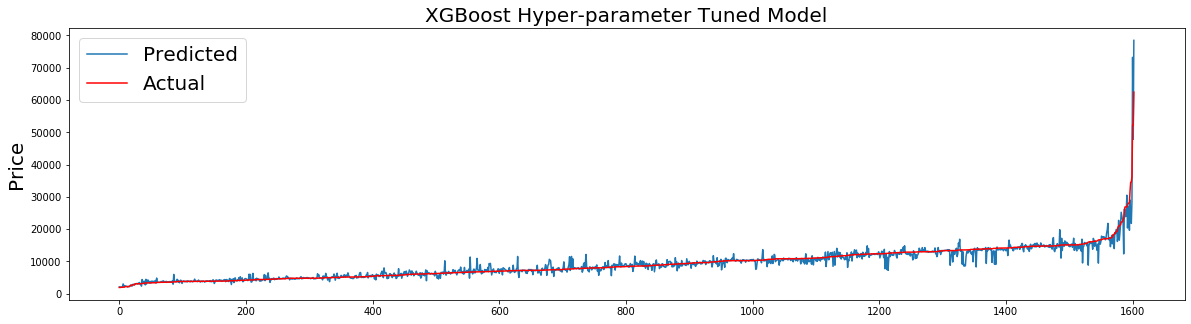

In [190]:
g_xgb = pd.DataFrame({'actual' : np.expm1(ytest),'predicted': np.expm1(gs1.predict(xtest_rfe))})
g_xgb = g_xgb.sort_values(by="actual").reset_index()
plt.figure(figsize = (20,5))
plt.plot(g_xgb['predicted'])
plt.plot(g_xgb['actual'], color = 'red')
plt.legend(['Predicted','Actual'],fontsize = 20)
plt.title('XGBoost Hyper-parameter Tuned Model', fontsize = 20)
plt.ylabel('Price', fontsize = 20)
plt.show()

In [185]:
# stacking
m1 = rf.predict(xtest_rfe)
m2 = xgb.predict(xtest_rfe)
m3 = gsrf.fit(xtrain_rfe, ytrain).predict(xtest_rfe)
m4 = gs1.predict(xtest_rfe)

# Create df of individual model predictoins
meta_df1 = pd.DataFrame(data = {'m1':m1,'m2':m2,'m3':m3,'m4':m4})

# using Ridge as meta model
meta_model = Ridge()   
meta_model.fit(meta_df1,ytest)  # Fit ridge with the predictions of individual models

# Use Cross validation to check model performance
metacv1 = cross_val_score(meta_model, meta_df1, ytest, cv = 8, scoring = my_func).mean()
print('For metamodel, cvs :', round(metacv1,4))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.0s finished


For metamodel, cvs : -0.011278004508974006


In [187]:
# meta model pred on test data
m11 = rf.predict(test_rfe)
m22 = xgb.predict(test_rfe)
m33 = gsrf.predict(test_rfe)
m44 = gs1.predict(test_rfe)

meta_df2 = pd.DataFrame(data = {'m11':m11,'m2':m22,'m3':m33,'m4':m44})
meta_model_prediction = meta_model.predict(meta_df2)

array([8.72464455, 8.24628744, 9.37565451, ..., 9.50889102, 8.60368992,
       8.84388941])

In [183]:
# Converting Predicted price to true scale
sub1 = []
for i in range(len(sub)):
    sub1.append((np.expm1(meta_model_prediction[i])))
    
# Create df & export
subm = pd.DataFrame({'Price':sub1})
subm.to_csv('sub7_ss0.9.csv', index = False)

array([8.697708, 8.229667, 9.365617, ..., 9.54686 , 8.605243, 8.843475],
      dtype=float32)